In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from keras import *
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import Adam, RMSprop
from keras.backend import clear_session

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/AML_project/train_manipulated_integrated.csv")

In [ ]:
y_train = train['trip_duration'].values.reshape(-1, 1)

X_train = train.drop(columns = ['trip_duration'])

#divisione train test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.30,
                                                  random_state = 1234)


In [ ]:
#divisione train validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15,
                                                  random_state = 1234)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(857057, 48)
(151246, 48)
(432130, 48)


In [ ]:
#si separano le dummies dalle quantitative

X_train_to_stand = X_train[['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']]

X_train_not_stand = X_train.drop(columns = ['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']).values


X_val_to_stand = X_val[['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']]

X_val_not_stand = X_val.drop(columns = ['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']).values

X_test_to_stand = X_test[['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']]

X_test_not_stand = X_test.drop(columns = ['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']).values

In [ ]:
#standardizzazione
scaler = StandardScaler()

X_train_stand = scaler.fit_transform(X_train_to_stand)
y_train_stand = scaler.fit(y_train).transform(y_train)

X_val_stand = scaler.fit(X_train_to_stand).transform(X_val_to_stand)
y_val_stand = scaler.fit(y_train).transform(y_val)

X_test_stand = scaler.fit(X_train_to_stand).transform(X_test_to_stand)
y_test_stand = scaler.fit(y_train).transform(y_test)

In [ ]:
X_train = np.concatenate((X_train_stand, X_train_not_stand), axis = 1)
X_val = np.concatenate((X_val_stand, X_val_not_stand), axis = 1)
X_test = np.concatenate((X_test_stand, X_test_not_stand), axis = 1)

y_train = y_train_stand
y_val = y_val_stand
y_test = y_test_stand

In [ ]:
X_train.shape

(857057, 48)

In [ ]:
#modello con parametri discrezionali

initializer = tf.keras.initializers.GlorotUniform()

opt = tf.keras.optimizers.SGD(learning_rate=0.002 , momentum=0.3, 
                              nesterov = False)

model_no_opt = Sequential()
model_no_opt.add(Dense(256, input_shape = (48,),
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(128,
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(128,
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(32,
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(1,
                activation = "linear", 
                kernel_initializer=initializer))
model_no_opt.compile(loss = "mse", optimizer=opt, metrics = [tf.keras.metrics.RootMeanSquaredError()])

model_no_opt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               12544     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

history_no_opt = model_no_opt.fit(X_train, y_train, epochs = 100, 
            batch_size = 128, validation_data=(X_val, y_val),
            shuffle = True,
            callbacks = es,
            verbose=2)

Epoch 1/100
6696/6696 - 15s - loss: 0.4650 - root_mean_squared_error: 0.6819 - val_loss: 0.3365 - val_root_mean_squared_error: 0.5801
Epoch 2/100
6696/6696 - 13s - loss: 0.3911 - root_mean_squared_error: 0.6254 - val_loss: 0.3207 - val_root_mean_squared_error: 0.5663
Epoch 3/100
6696/6696 - 13s - loss: 0.3716 - root_mean_squared_error: 0.6096 - val_loss: 0.3099 - val_root_mean_squared_error: 0.5567
Epoch 4/100
6696/6696 - 13s - loss: 0.3596 - root_mean_squared_error: 0.5996 - val_loss: 0.3036 - val_root_mean_squared_error: 0.5510
Epoch 5/100
6696/6696 - 13s - loss: 0.3513 - root_mean_squared_error: 0.5927 - val_loss: 0.2953 - val_root_mean_squared_error: 0.5434
Epoch 6/100
6696/6696 - 13s - loss: 0.3453 - root_mean_squared_error: 0.5876 - val_loss: 0.2958 - val_root_mean_squared_error: 0.5439
Epoch 7/100
6696/6696 - 13s - loss: 0.3393 - root_mean_squared_error: 0.5825 - val_loss: 0.2909 - val_root_mean_squared_error: 0.5394
Epoch 8/100
6696/6696 - 13s - loss: 0.3363 - root_mean_squared

In [ ]:
train_no_opt_mse = history_no_opt.history['loss']
val_no_opt_mse = history_no_opt.history['val_loss']

train_no_opt_rmse = history_no_opt.history['root_mean_squared_error']
val_no_opt_rmse = history_no_opt.history['val_root_mean_squared_error']

In [ ]:
perf_no_opt_dropout = pd.DataFrame({'epochs': list(np.arange(0, 68)[0:68]), 
                               'loss':train_no_opt_mse,
                               'val_loss':val_no_opt_mse,
                               'rmse': train_no_opt_rmse,
                               'val_rmse': val_no_opt_rmse})

#backup per non riallenare
perf_no_opt_dropout.to_csv("/content/drive/MyDrive/AML_project/modelli/modelli salvati/Dropout/perf_no_opt_dropout.csv", 
                           index = False)
model_no_opt.save("/content/drive/MyDrive/AML_project/modelli/moelli salvati/Dropout/model_no_opt_dropout.h5")

In [ ]:
#modello con iperparametri ottimizzati

activations = "relu"
units_1 = 240
units_2 = 112
units_3 = 128

dropout = 0.10

initializer = tf.keras.initializers.GlorotUniform(1234)

opt = tf.keras.optimizers.SGD(learning_rate= 0.002, momentum=0.3, 
                              nesterov = False)


model = Sequential()
model.add(Dense(units_1, input_shape = (48,),
                activation = activations, 
                kernel_initializer=initializer))
model.add(Dropout(dropout, seed = 1000))
model.add(Dense(units_2,
                activation = activations, 
                kernel_initializer=initializer))
model.add(Dropout(dropout, seed = 1000))
model.add(Dense(units_3,
                activation = activations, 
                kernel_initializer=initializer))
model.add(Dropout(dropout, seed = 1000))
model.add(Dense(1,
                activation = "linear", 
                kernel_initializer=initializer))
model.compile(loss = "mse", optimizer=opt
, metrics = [tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 240)               11760     
_________________________________________________________________
dropout_4 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 112)               26992     
_________________________________________________________________
dropout_5 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               14464     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = 100, 
            batch_size = 128, validation_data=(X_val, y_val),
            callbacks = es,
            verbose=2)

Epoch 1/100
6696/6696 - 12s - loss: 0.4076 - root_mean_squared_error: 0.6385 - val_loss: 0.3194 - val_root_mean_squared_error: 0.5651
Epoch 2/100
6696/6696 - 12s - loss: 0.3496 - root_mean_squared_error: 0.5913 - val_loss: 0.3015 - val_root_mean_squared_error: 0.5491
Epoch 3/100
6696/6696 - 12s - loss: 0.3330 - root_mean_squared_error: 0.5771 - val_loss: 0.2907 - val_root_mean_squared_error: 0.5392
Epoch 4/100
6696/6696 - 12s - loss: 0.3239 - root_mean_squared_error: 0.5691 - val_loss: 0.2856 - val_root_mean_squared_error: 0.5344
Epoch 5/100
6696/6696 - 12s - loss: 0.3185 - root_mean_squared_error: 0.5644 - val_loss: 0.2821 - val_root_mean_squared_error: 0.5312
Epoch 6/100
6696/6696 - 12s - loss: 0.3141 - root_mean_squared_error: 0.5604 - val_loss: 0.2795 - val_root_mean_squared_error: 0.5287
Epoch 7/100
6696/6696 - 12s - loss: 0.3107 - root_mean_squared_error: 0.5574 - val_loss: 0.2775 - val_root_mean_squared_error: 0.5268
Epoch 8/100
6696/6696 - 12s - loss: 0.3080 - root_mean_squared

Performance

In [ ]:
metrics_no_opt_train = model_no_opt.evaluate(X_val, y_val, verbose = 0, batch_size = 128)
metrics_no_opt_val = model_no_opt.evaluate(X_val, y_val, verbose = 0, batch_size = 128)
metrics_no_opt_test = model_no_opt.evaluate(X_test, y_test, verbose = 0, batch_size = 128)

metrics_opt_train = model.evaluate(X_train, y_train, verbose = 0, batch_size = 128)
metrics_opt_val = model.evaluate(X_val, y_val, verbose = 0, batch_size = 128)
metrics_opt_test = model.evaluate(X_test, y_test, verbose = 0, batch_size = 128)
##################################

mse_no_opt_train = metrics_no_opt_train[0] #mse
mse_no_opt_val = metrics_no_opt_val[0] #mse
mse_no_opt_test = metrics_no_opt_test[0] #mse

rmse_no_opt_train = metrics_no_opt_train[1] #rmse
rmse_no_opt_val = metrics_no_opt_val[1] #rmse
rmse_no_opt_test = metrics_no_opt_test[1] #rmse

#################################################

mse_opt_train = metrics_opt_train[0] #mse
mse_opt_val = metrics_opt_val[0] #mse
mse_opt_test = metrics_opt_test[0] #mse

rmse_opt_train = metrics_opt_train[1] #rmse
rmse_opt_val = metrics_opt_val[1] #rmse
rmse_opt_test = metrics_opt_val[1] #rmse

###############################################

print("mse train opt", mse_opt_train)
print("mse val opt", mse_opt_val)
print("mse test opt", mse_opt_test)

print("rmse train opt", rmse_opt_train)
print("rmse val opt", rmse_opt_val)
print("rmse test opt", rmse_opt_test)

############################################
print("___________________________")
print("mse train no opt", mse_no_opt_train)
print("mse val no opt", mse_no_opt_val)
print("mse test no opt", mse_no_opt_test)

print("rmse train no opt", rmse_no_opt_train)
print("rmse val no opt", rmse_no_opt_val)
print("rmse test no opt", rmse_no_opt_test)

mse train opt 0.2519571781158447
mse val opt 0.23958267271518707
mse test opt 0.2496432512998581
mse train opt 0.5019533634185791
mse val opt 0.48947182297706604
mse test opt 0.48947182297706604
___________________________
mse train no opt 0.25405195355415344
mse val no opt 0.25405195355415344
mse test no opt 0.26494190096855164
mse train no opt 0.5040356516838074
mse val no opt 0.5040356516838074
mse test no opt 0.5147250890731812


In [ ]:
train_opt_loss = history.history['loss']
val_opt_loss = history.history['val_loss']

train_opt_rmse = history.history['root_mean_squared_error']
val_opt_rmse = history.history['val_root_mean_squared_error']

perf_opt_dropout = pd.DataFrame({'epochs': list(np.arange(0, 100)[0:100]), 
                               'loss':train_opt_loss,
                               'val_loss':val_opt_loss,
                            'rmse': train_opt_rmse,
                            'val_rmse':val_opt_rmse})

#backup per npn riallenare
perf_opt_dropout.to_csv("/content/drive/MyDrive/AML_project/modelli/modelli salvati/Dropout/perf_opt_dropout.csv", index = False)
model.save("/content/drive/MyDrive/AML_project/modelli/modelli salvati/Dropout/model_opt_dropout.h5")

Text(0.5, 1.0, 'confronto performance regolarizzazione Dropout')

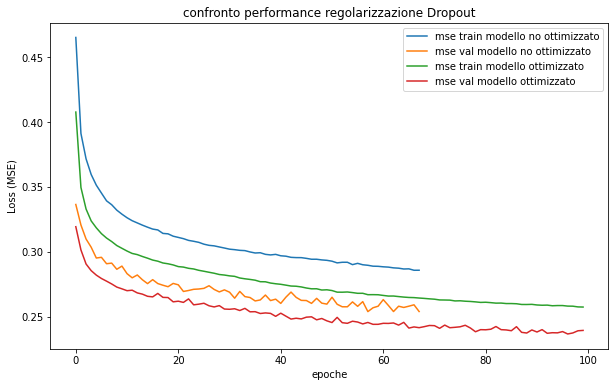

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_no_opt_mse, label = "mse train modello no ottimizzato")
plt.plot(val_no_opt_mse, label = "mse val modello no ottimizzato")
plt.plot(train_opt_loss, label = "mse train modello ottimizzato")
plt.plot(val_opt_loss, label = "mse val modello ottimizzato")
plt.legend()
plt.ylabel("Loss (MSE)")
plt.xlabel("epoche")
plt.title("confronto performance regolarizzazione Dropout")